# Predicting Recessions with DataRobot
In this use case, we'll try to predict whether or not the US economy is heading into a recession within the next three months. While hopefully it's not necessary to say so, let's just get this out of the way up front: don't actually invest your real money according to the results of this notebook. The real value comes from learning about how to use the Python client of the DataRobot API.


## Topics Covered in this Notebook
Here is a list of things we'll touch on during this notebook:

- Installing the `datarobot` package
- Configuring the client
- Creating a project
- Using a column from the dataset for a custom partitioning scheme
- Omitting one of the source columns from the modeling process
- Run the automated modeling process
- Generating predictions from a finished model

The dataset required for this notebook can be produced by running the notebook `Generating a Dataset from FRBSL`, located in this same directory.

## Prerequisites
In order to run this notebook yourself, you will need the following:

- A DataRobot API token
- [matplotlib](http://matplotlib.org/users/installing.html) for the visualizations at the end

### Installing the `datarobot` package
The `datarobot` package is hosted on PyPI. You can install it via:
```
pip install datarobot
```
from the command line. Its main dependencies are `numpy` and `pandas`, which could take some time to install on a new system. We highly recommend use of virtualenvs to avoid conflicts with other dependencies in your system-wide python installation.

## Getting started
This line imports the `datarobot` package. By convention, we always import it with the alias `dr`.

In [1]:
import datarobot as dr

## Other important imports
We'll use these in this notebook as well. If the previous cell and the following
cell both run without issue, you're in good shape.

In [2]:
import re
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Configure the Python Client
Configuring the client requires the following two things:

- A DataRobot endpoint - where the API server can be found
- A DataRobot API token

The client can be configured in several ways. The example we'll use in this notebook is to point to a `yaml` file that has the information. This is the structure of that file:
```yaml
endpoint: https://app.datarobot.com/api/v2/
token: not-my-real-token
```

If you want to run this notebook without changes, please save your configuration in the same directory from which you run this notebook, and call it `drconfig.yaml`.

In [3]:
dr.Client(config_path='drconfig.yaml')

## Find the data in your filesystem
If you have run the other notebook, it will have written a file to disk. In the next cell, we'll try
to find it in this directory. If it's not here, you can help the notebook continue by defining the variable `filename` to point to that file.

In [4]:
usecase_name_regex = re.compile('financials-.*\.csv')

files = [fname for fname in os.listdir('.')
         if usecase_name_regex.match(fname)]
filename = files[0]
print('Using {}'.format(filename))

Using financials-2016-03-22.csv


## Create the Project
Here, we use the `datarobot` package to upload a new file and create a project. The name of the project is optional, but can be helpful when trying to sort among many projects on DataRobot.

In [5]:
now = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M')
project_name = 'FRB{}'.format(now)
proj = dr.Project.create(sourcedata=filename,
                         project_name=project_name)

## Create a custom partition scheme
This problem has a time component to it, so it wouldn't do us very much good to train on data from the present and predict on the past. In creating the dataset, the column `TVH` was used to indicate which partition each row should belong to. The training (`T`) data all precedes the validation (`V`) data in time, which in turn precedes the holdout (`H`) data. By using a `UserTVH` column we can specify this partition should be used by DataRobot. Absent this information, DataRobot defaults to randomly separating rows into training, validation, and holdout.

In [6]:
proj_partition = dr.UserTVH(user_partition_col='TVH',
                            training_level='T',
                            validation_level='V',
                            holdout_level='H')

## Omit a column from modeling
The `Date` column is a data leak, so we don't want it to be included in the modeling process. We can accomplish this by creating a featurelist that does not include it, and using that featurelist during modeling.

In [7]:
features = proj.get_features()
names_without_date = [feature.name for feature in features
                      if feature.name != 'Date']
flist = proj.create_featurelist('Without Date', names_without_date)

## Run the automated modeling process
Now we can start the modeling process. The target for this problem is called `US Recession in 13 Weeks` - a binary variable indicating whether or not the US economy was in recession 13 weeks after the week that a row represents.

We specify that the metric that should be used is `AUC`. Without a specification DataRobot would use the metric it recommends (in this case, it would have been `LogLoss`).

The `partitioning_method` is used to specify that we would like DataRobot to use the partitioning schema we specified previously.

The `featurelist_id` parameter tells DataRobot to model on that specific featurelist, rather than the default `Informative Features`.

Finally, the `worker_count` parameter specifies how many workers should be used for this project. Keep in mind, you might not have access to 10 workers. If you need more resources than what has been allocated to you, you should think about upgrading your license.

The last command in this cell is just a blocking loop that periodically checks on the project to see if it is done, printing out the number of jobs in progress and in the queue along the way so you can see progress. The automated model exploration process will occasionally add more jobs to the queue, so don't be alarmed if the number of jobs does not strictly decrease over time.

In [8]:
target_name = 'US Recession in 13 Weeks'
proj.set_target(target_name,
                metric='AUC',
                partitioning_method=proj_partition,
                featurelist_id=flist.id,
                worker_count=10)

proj.wait_for_autopilot()

In progress: 10, queued: 18 (waited: 0s)
In progress: 10, queued: 18 (waited: 0s)
In progress: 10, queued: 18 (waited: 1s)
In progress: 10, queued: 18 (waited: 1s)
In progress: 10, queued: 18 (waited: 3s)
In progress: 10, queued: 16 (waited: 4s)
In progress: 10, queued: 10 (waited: 8s)
In progress: 10, queued: 7 (waited: 15s)
In progress: 8, queued: 0 (waited: 28s)
In progress: 4, queued: 0 (waited: 48s)
In progress: 2, queued: 0 (waited: 68s)
In progress: 1, queued: 0 (waited: 88s)
In progress: 8, queued: 0 (waited: 109s)
In progress: 4, queued: 0 (waited: 129s)
In progress: 2, queued: 0 (waited: 149s)
In progress: 4, queued: 0 (waited: 169s)
In progress: 0, queued: 0 (waited: 190s)


## What just happened?
We can see how many models DataRobot built for this project by querying. Each of them has been tuned individually. Models that appear to have the same name differ either in the amount of data used in training or in the preprocessing steps used (or both).

In [9]:
models = proj.get_models()
for idx, model in enumerate(models):
    print('[{}]: {} - {}'.
          format(idx, model.metrics['AUC']['validation'], model.model_type))

[0]: 0.97916 - eXtreme Gradient Boosted Trees Classifier
[1]: 0.97648 - eXtreme Gradient Boosted Trees Classifier
[2]: 0.97426 - ExtraTrees Classifier (Gini)
[3]: 0.96448 - AVG Blender
[4]: 0.96262 - eXtreme Gradient Boosted Trees Classifier
[5]: 0.95564 - ENET Blender
[6]: 0.95555 - Advanced AVG Blender
[7]: 0.95511 - Nystroem Kernel SVM Classifier
[8]: 0.95511 - ENET Blender
[9]: 0.94964 - Gradient Boosted Trees Classifier
[10]: 0.94748 - Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)
[11]: 0.94716 - ExtraTrees Classifier (Gini)
[12]: 0.94426 - Nystroem Kernel SVM Classifier
[13]: 0.94176 - RandomForest Classifier (Gini)
[14]: 0.93693 - Gradient Boosted Trees Classifier
[15]: 0.93073 - Gradient Boosted Trees Classifier
[16]: 0.93002 - Gradient Boosted Trees Classifier
[17]: 0.92969 - RandomForest Classifier (Gini)
[18]: 0.92969 - RandomForest Classifier (Gini)
[19]: 0.9264 - Gradient Boosted Greedy Trees Classifier
[20]: 0.92 - RandomForest Classifier (Entropy)
[21]: 0

## Generating predictions from a finished model
So, what do these models think about the likelihood of a recession in the next 3 months? We can make predictions on the latest data to see what they see.

### These may not be the predictions you are looking for...
There are two ways to generate predictions in DataRobot, one using modeling workers and one using dedicated prediction workers. In this notebook we will use the former, which is slower, occupies one of your modeling worker slots, and has no real guarantees about latency because the jobs go through the project queue.

Why do we even have this slow prediction mechanism? Because of its limitations it is much easier for anticipate the load that it adds to the system, so we can provide it to everyone in a shared environment. 

For the faster, low latency, dedicated prediction solution, we would encourage you to look into an upgraded license of DataRobot, specifically one with dedicated prediction workers.

### Three step process
As just mentioned, these predictions go through the modeling queue, so there is a three-step process. The first step is to upload your dataset; the second is to generate the prediction jobs themselves. Finally, you need to retreive your predictions when the job is done.

In this case, we are generating predictions from the top 10 models in the project.

In [10]:
dataset = proj.upload_dataset(filename)

pred_jobs = [models[i].request_predictions(dataset.id) for i in range(10)]
all_preds = [pred_job.get_result_when_complete() for pred_job in pred_jobs]

## Bonus Section: Predicting the future
That concludes the "how-to" portion of the notebook. But we won't just leave you hanging... we've gone through all this trouble to try to predict the future. We might as well tell you what we saw.

### Get Ready to plot
It will be easier to plot the data if it all shares the same time-based index. Here in this cell we read the modeling data and use its index, then we attach the predictions from each of the models to that dataframe

In [11]:
plot_data = pd.read_csv(filename, index_col=0)

for idx, pred in enumerate(all_preds):
    plot_data['pred_{}'.format(idx)] = pred['positive_probability'].tolist()

### Plots!
We start by defining a helper function to plot the predictions together on the same plot.

Here we plot the predictions for every week in the dataset after the year 2000 (the holdout was all the data after the start of 1995).

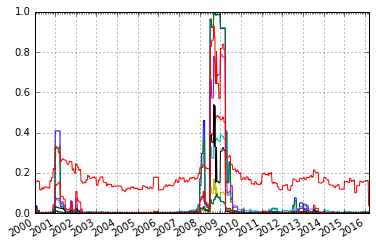

In [12]:
def plot_date_data(dataframe, column_names):
    x_axis = [datetime.datetime.strptime(x, '%Y-%m-%d')
              for x in dataframe.index]
    import matplotlib.dates as mdates
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    fig, ax = plt.subplots()

    for column_name in column_names:
        data = dataframe[column_name]
        ax.plot(x_axis, data)
        ax.hold(True)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)
    fig.autofmt_xdate()


plot_date_data(plot_data[plot_data.index > '2000-01-01'],
               ['pred_{}'.format(i) for i in range(10)])

The two spikes correspond to the dotcom bubble bursting in early 2001 and the Great Recession.

But... were the models predictive or postdictive?

### A closer look at the Great Recession.

Let's zoom in on 2007 and 2008, when things really went sideways.

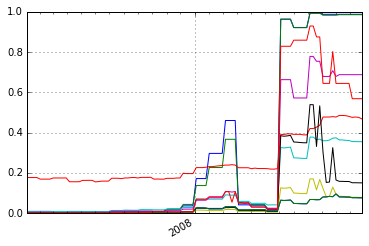

In [13]:
plot_date_data(plot_data[(plot_data.index > '2007-01-01') &
                         (plot_data.index < '2009-01-01')],
               ['pred_{}'.format(i) for i in range(10)])

Some of these models were picking up on some signal in the early months of 2008, shortly before stocks went for a dive. But then again, they flatlined before the real tumult happened, so take it with a grain of salt.

## But what about now? Are we headed for a recession?

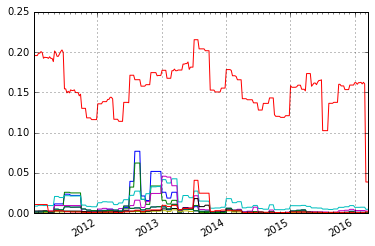

In [14]:
plot_date_data(plot_data[plot_data.index > '2011-01-01'],
               ['pred_{}'.format(i) for i in range(10)])

Nope.

## What can we say about these models?
It would seem like we used a lot of information in building and evaluation these models. It does include more than 3000 weeks of data. But how much information is in this data?

For this specific problem, we know that the state of the economy does not jump around with great velocity. So we don't really have 3000 independent observations, because the observations in one week convey a lot of information about the values of the nearby weeks. So what information do we actually have?

In this case, while we had many weeks in which there were observed recessions in the economy, we are actually only looking at the event of entering (or exiting) a recession, which is limited by the total number of recessions. In this case that number was only 11; 6 were used in training, 3 in validation, and 2 in the holdout. That's not a lot of information to train on.

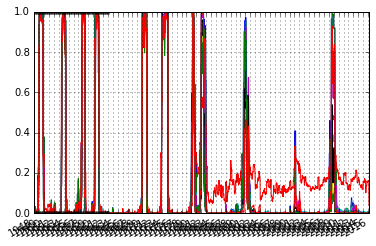

In [15]:
plot_date_data(plot_data, ['pred_{}'.format(i) for i in range(10)])